In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import researchpy as rp

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import statsmodels.api as sm
import scikit_posthocs as sp
import statsmodels.formula.api as smf
from matplotlib import image as mpimg
import matplotlib 

from PIL import Image
from IPython.display import display

cutoff = 290

def cohen_d(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    print('Effect size d: {}'.format((u1 - u2) / s))

# Dataset

In [2]:
df = pd.read_csv('DATASET.csv', header=[0], index_col=[0])
df.position = df.position.apply(lambda x: {0:'centre', 2: 'left', 1: 'right'}[x])
print(df.head())

  position  method  run  traj_length  collisions  accept1 path1 plan1  steps1  \
0   centre  single    0   911.176207           0      NaN   NaN   NaN     NaN   
1   centre  single    1   891.171398           0      NaN   NaN   NaN     NaN   
2   centre  single    2   894.478019           0      NaN   NaN   NaN     NaN   
3   centre  single    3  1540.525885           1      NaN   NaN   NaN     NaN   
4   centre  single    4   879.951722           0      NaN   NaN   NaN     NaN   

   latency1  ... mem_used_max cache_min cache_max  swap_total_min  \
0       NaN  ...         83.8       197       205             100   
1       NaN  ...         83.9       198       206             100   
2       NaN  ...         78.0       197       205             100   
3       NaN  ...         82.2       197       208             100   
4       NaN  ...         82.8       197       206             100   

   swap_total_max  swap_free_min  swap_free_max  swap_used_min  swap_used_max  \
0             100

# Trajectories

In [3]:
df_traj = df[['method', 'position', 'traj_length']]
df_traj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   method       90 non-null     object 
 1   position     90 non-null     object 
 2   traj_length  90 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.8+ KB


In [4]:
df_traj.shape

(90, 3)

# Method

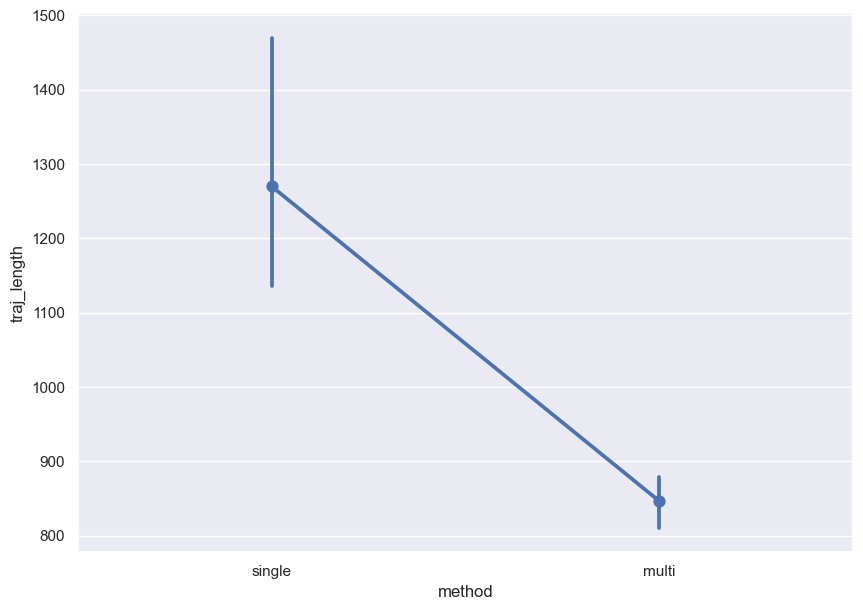

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=df_traj, x='method', y='traj_length')
plt.show()

In [6]:
print(df.groupby(by='method').traj_length.describe().T)

method        multi       single
count     45.000000    45.000000
mean     846.666903  1269.898231
std      117.383287   556.705021
min      489.020087   877.969667
25%      763.136229   923.995354
50%      906.991571  1115.916107
75%      918.448268  1403.412626
max     1048.509573  4243.018440


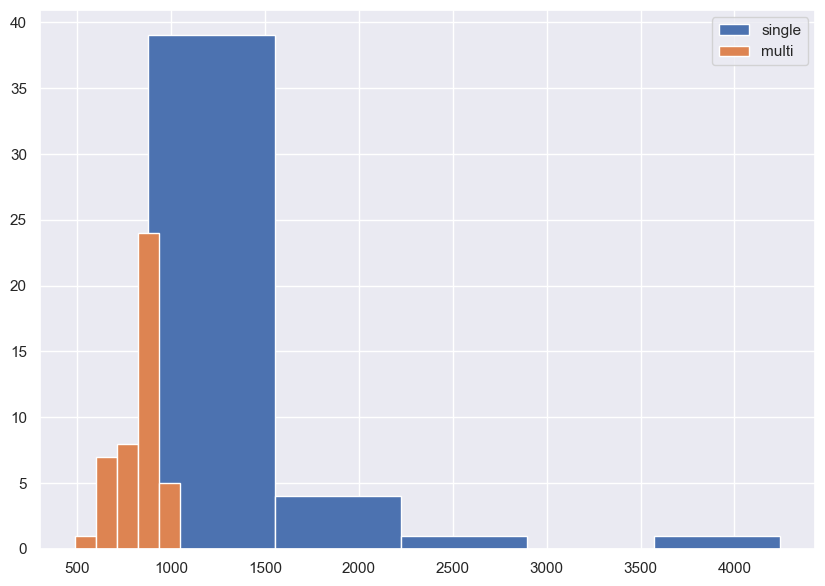

In [7]:
single = df_traj[df_traj.method == 'single']
multi = df_traj[df_traj.method == 'multi']

plt.figure(figsize=(10, 7))
single.traj_length.hist(label='single', bins=5)
multi.traj_length.hist(label='multi', bins=5)
plt.legend()
plt.show()

Unequal variances, skewed and median seems more descriptive of the central tendency.

## Normality assumption

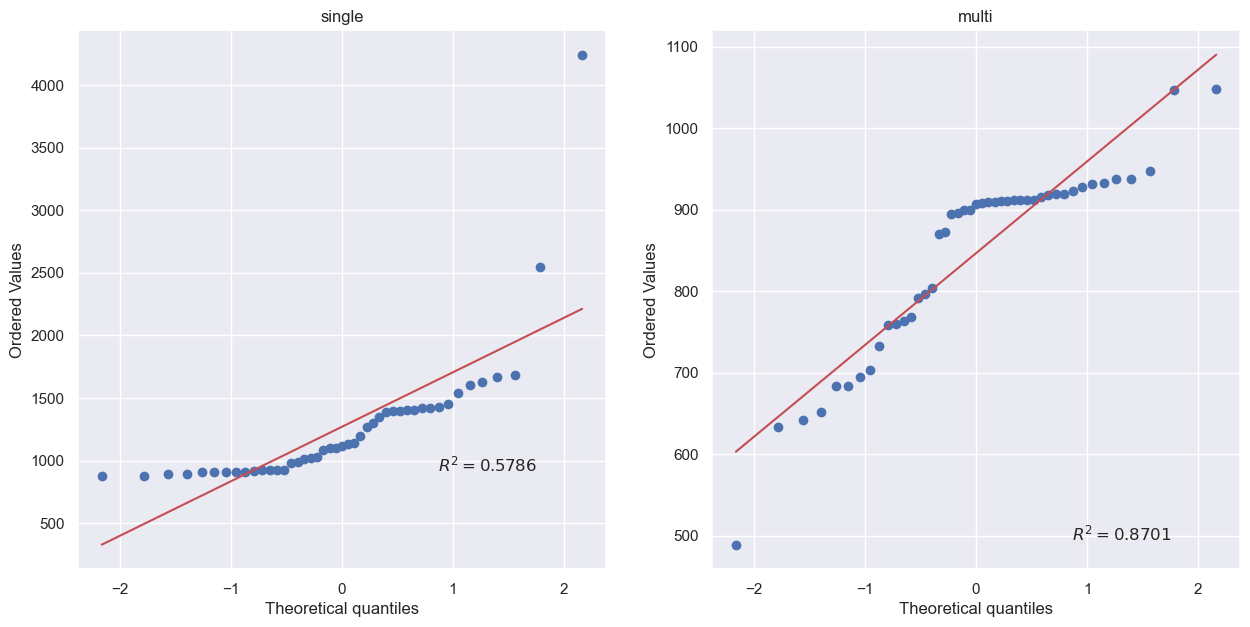

In [8]:
fig, ax = plt.subplots(1, 2, figsize= (15, 7))
stats.probplot(single.traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('single', fontsize=12)
stats.probplot(multi.traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('multi', fontsize=12)
plt.show()

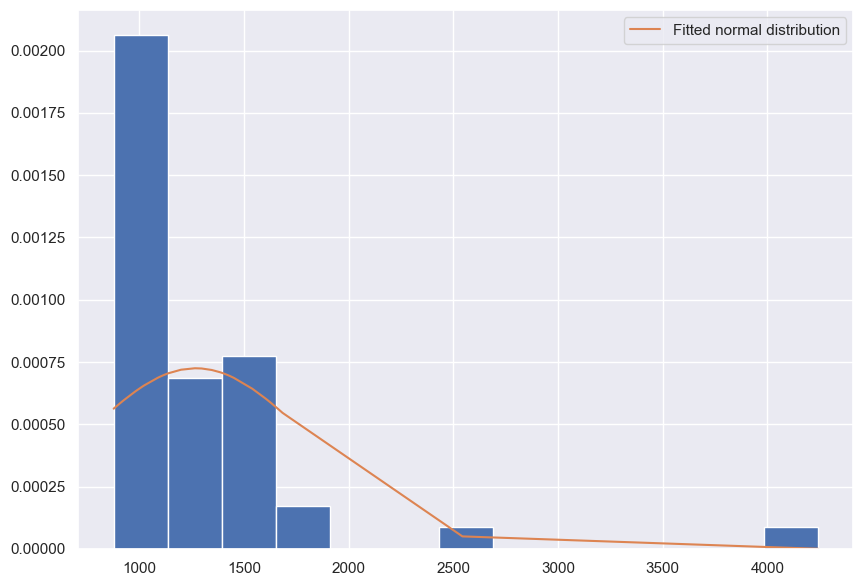

In [9]:
def normal_plot(variable):
    variable = variable.copy()
    variable.values.sort()
    mean, std = stats.norm.fit(variable, loc=0)
    pdf_norm = stats.norm.pdf(variable, mean, std)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(variable, bins='auto', density=True)
    ax.plot(variable, pdf_norm, label='Fitted normal distribution')
    ax.legend()
    
normal_plot(single.traj_length)

In [10]:
def normal_test_battery(sample):
    stat, p = stats.shapiro(sample)
    if p < 0.05:
        print('Shapiro-Wilk s={:.3f} p={:.3f}, data does not look normal (reject H0)'.format(stat, p))
    else:
        print('Shapiro-Wilk s={:.3f} p={:.3f}, data looks normal (accept H0)'.format(stat, p))

    try:
        stat, p = stats.normaltest(sample)
        if p < 0.05:
            print('D’Agostino K^2 s={:.3f} p={:.3f}, data does not look normal (reject H0)'.format(stat, p))
        else:
            print('D’Agostino K^2 s={:.3f} p={:.3f}, data looks normal (accept H0)'.format(stat, p))
    except ValueError:
        pass
    
    result = stats.anderson(sample)
    print('\nAnderson-Darling s={}'.format(result.statistic))
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('{:.3f}: {:.3f}, data looks normal (accept H0)'.format(sl, cv))
        else:
            print('{:.3f}: {:.3f}, data does not look normal (reject H0)'.format(sl, cv))
            
normal_test_battery(single.traj_length)

Shapiro-Wilk s=0.601 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=66.484 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=4.266871019796696
15.000: 0.535, data does not look normal (reject H0)
10.000: 0.609, data does not look normal (reject H0)
5.000: 0.731, data does not look normal (reject H0)
2.500: 0.853, data does not look normal (reject H0)
1.000: 1.014, data does not look normal (reject H0)


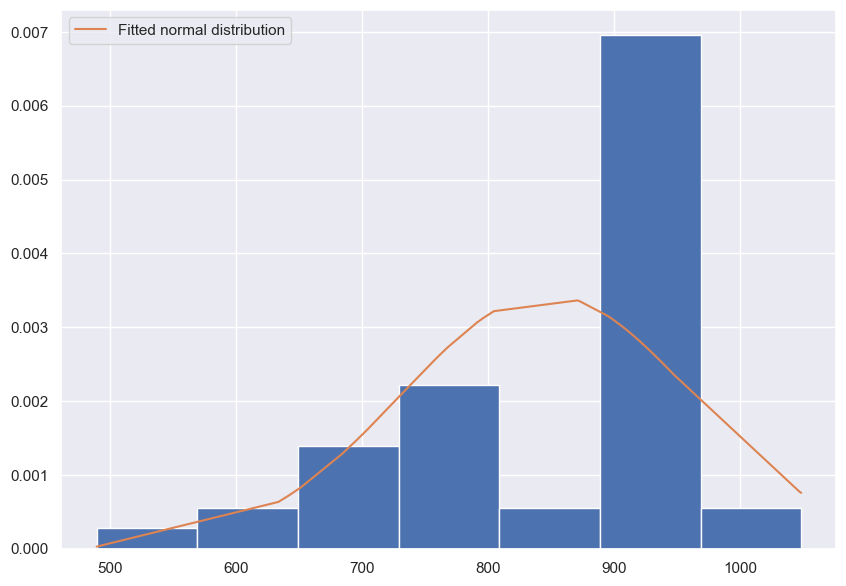

In [11]:
normal_plot(multi.traj_length)

In [12]:
normal_test_battery(multi.traj_length)

Shapiro-Wilk s=0.875 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=7.722 p=0.021, data does not look normal (reject H0)

Anderson-Darling s=2.653940661486274
15.000: 0.535, data does not look normal (reject H0)
10.000: 0.609, data does not look normal (reject H0)
5.000: 0.731, data does not look normal (reject H0)
2.500: 0.853, data does not look normal (reject H0)
1.000: 1.014, data does not look normal (reject H0)


Doesn't seem normal as it stands. Can we remove outliers?

## Examine outliers

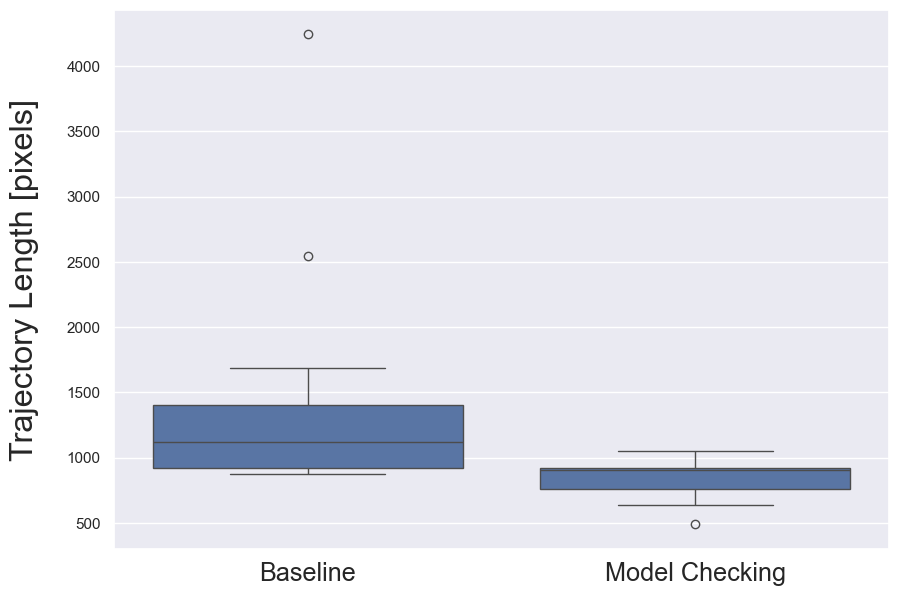

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=df_traj, x='method', y='traj_length')
ax.set_ylabel('Trajectory Length [pixels]', fontsize=18*1.3, labelpad=20)
ax.set_xlabel('', fontsize=18*1.3, labelpad=20)
ax.set_xticklabels(['Baseline', 'Model Checking'], fontsize=14*1.3)
plt.savefig('method.png', transparent=False)
plt.show()

In [14]:
single_ = sp.outliers_iqr(df_traj[df_traj.method == 'single'].traj_length)
multi_ = sp.outliers_iqr(df_traj[df_traj.method == 'multi'].traj_length)
print('single: {}  multi: {}'.format(len(single_), len(multi_)))

single: 43  multi: 44


In [15]:
single_outliers = sp.outliers_iqr(df_traj[df_traj.method == 'single'].traj_length, ret='outliers')
multi_outliers = sp.outliers_iqr(df_traj[df_traj.method == 'multi'].traj_length, ret='outliers')
single_outliers

array([2543.661652, 4243.01844 ])

In [16]:
multi_outliers

array([489.0200873])

In [17]:
print(single[single.traj_length > 2000])

    method position  traj_length
72  single     left  2543.661652
74  single     left  4243.018440


Inspection of the raw data reveals that these are unusual but acceptable observations.  No issues with the RPI for any runs and we can expect some randomness in the use of a single control task.  Indeed, that is one of the reasons we use model checking - to improve on this aspect of randomness which can lead to getting trapped.  Starting position is left in both cases and as the robot veers right it encounters a corner of the cul-de-sac in both cases leading it to get trapped and longer trajectories.

In [18]:
print(multi[multi.traj_length < 500])

   method position  traj_length
45  multi    right   489.020087


In [19]:
print(multi.traj_length.describe())

count      45.000000
mean      846.666903
std       117.383287
min       489.020087
25%       763.136229
50%       906.991571
75%       918.448268
max      1048.509573
Name: traj_length, dtype: float64


In [20]:
IQR = 918.44 - 763.13
763.13 - 1.5 * IQR

530.165

Inspection of the raw data reveals that this is not terribly unusual.  No issues with the RPI, rather the shortness of this trajectory seems related to the influence of starting position, in this case the right, and error in the real execution as again the robot veers right.  Not even a missive outlier by all accounts, just the shortest trajectory in the dataset.

In general, the outliers here seem to be due to acceptable error in the real execution combined with the influence of starting position.  

## Variances

In [21]:
stats.levene(single.traj_length, multi.traj_length, center='median')

LeveneResult(statistic=9.312980259341352, pvalue=0.003007887667452634)

In [22]:
print(single.traj_length.std(), multi.traj_length.std(), sep=', ')

556.7050205414378, 117.38328674571274


Unequal as seen in the histogram above, affected by outliers we can't remove.  Is there a correlation?

In [23]:
print(stats.pearsonr(multi.traj_length, single.traj_length))

PearsonRResult(statistic=-0.16124982345464958, pvalue=0.28996345690524394)


## Non-parametric testing

In [24]:
print(stats.mannwhitneyu(multi.traj_length, single.traj_length, alternative='less'))

MannwhitneyuResult(statistic=251.0, pvalue=4.0990942801502516e-10)


In [25]:
df_traj['rank'] = df_traj.traj_length.rank(method='min').values
single_ranked = df_traj[df_traj.method == 'single']
multi_ranked = df_traj[df_traj.method == 'multi']

def mannwhitney_stats(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    T1 = sample1.sum()
    print('Sum of ranks sample 1: {}'.format(T1))
    print('Mean rank sample 1: {}'.format(T1/n1))
    U1 = n1 * n2 + (n1 * (n1 + 1) / 2) - T1
    print('U sample 1: {}'.format(U1))
    print()
    T2 = sample2.sum()
    print('Sum of ranks sample 2: {}'.format(T2))
    print('Mean rank sample 2: {}'.format(T2/n2))
    U2 = n1 * n2 + (n2 * (n2 + 1) / 2) - T2
    print('U sample 2: {}'.format(U2))
    print()
    U = min([U1, U2])
    print('Test stat U: {}'.format(U))
    mU = n1 * n2 / 2
    print('Expected value of U: {}'.format(mU))
    sigU = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 2)
    print('Standard error of U: {}'.format(sigU))
    z = (U - mU) / sigU
    print('z-value: {}'.format(z))
    r = abs(z) / np.sqrt(n1)
    print('Effect size r={}'.format(r))
    
mannwhitney_stats(single_ranked['rank'], multi_ranked['rank'])

Sum of ranks sample 1: 2809.0
Mean rank sample 1: 62.422222222222224
U sample 1: 251.0

Sum of ranks sample 2: 1286.0
Mean rank sample 2: 28.57777777777778
U sample 2: 1774.0

Test stat U: 251.0
Expected value of U: 1012.5
Standard error of U: 303.5415951727209
z-value: -2.508717131721905
Effect size r=0.3739774695232315


Permutation test pvalue=9.99990000099999e-06


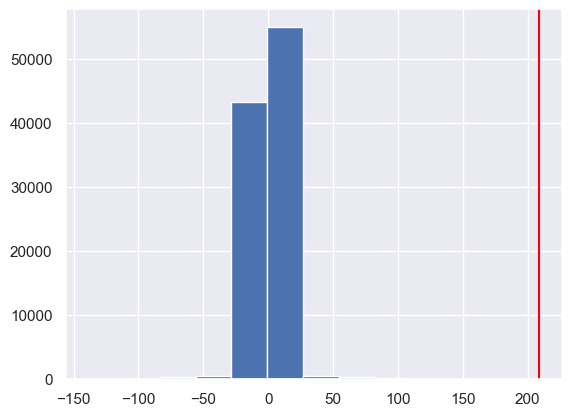

In [26]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((single.traj_length.values, multi.traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(single.traj_length.values, multi.traj_length.values)
plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=9.99990000099999e-06


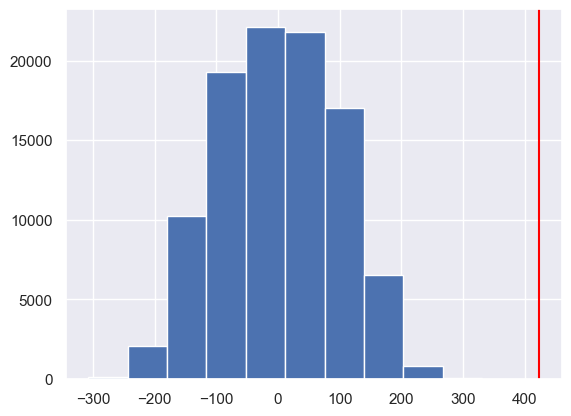

In [27]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((single.traj_length.values, multi.traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(single.traj_length.values, multi.traj_length.values)
plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

# Position

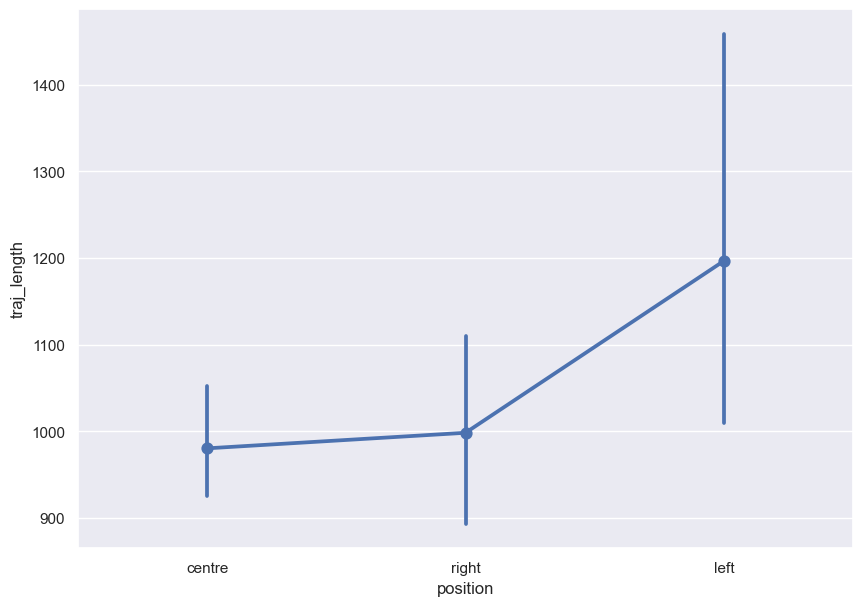

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=df_traj, x='position', y='traj_length')
plt.show()

Text(0.5, 1.0, 'right')

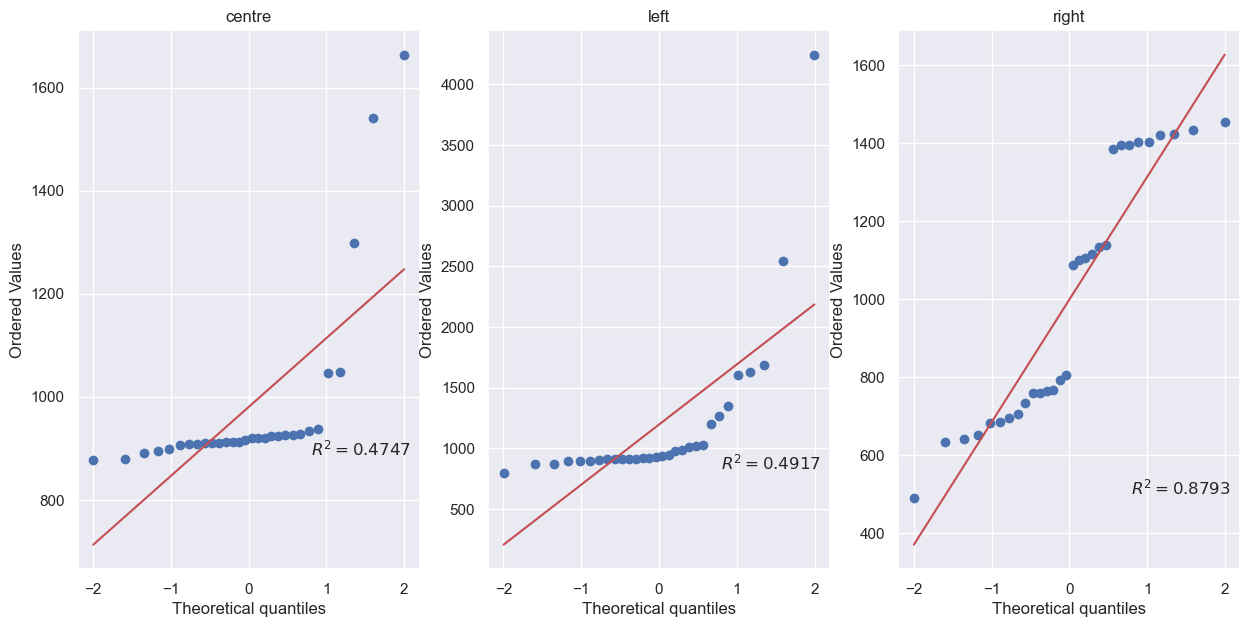

In [29]:
fig, ax = plt.subplots(1, 3, figsize= (15, 7))
stats.probplot(df_traj[df_traj.position == 'centre'].traj_length, plot=ax[0], rvalue=True)
ax[0].set_title('centre', fontsize=12)
stats.probplot(df_traj[df_traj.position == 'left'].traj_length, plot=ax[1], rvalue=True)
ax[1].set_title('left', fontsize=12)
stats.probplot(df_traj[df_traj.position == 'right'].traj_length, plot=ax[2], rvalue=True)
ax[2].set_title('right', fontsize=12)

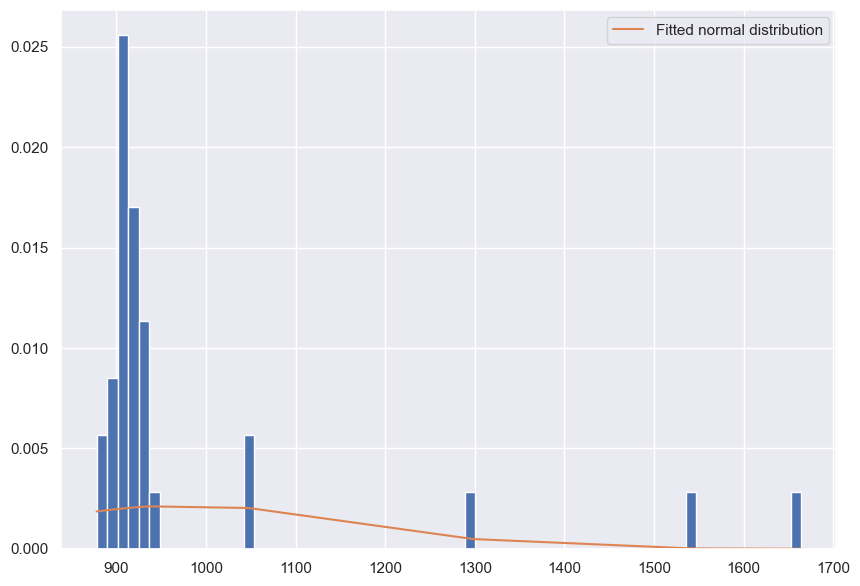

In [30]:
normal_plot(df_traj[df_traj.position == 'centre'].traj_length)

In [31]:
normal_test_battery(df_traj[df_traj.position == 'centre'].traj_length)

Shapiro-Wilk s=0.491 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=37.188 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=6.606598603971982
15.000: 0.521, data does not look normal (reject H0)
10.000: 0.593, data does not look normal (reject H0)
5.000: 0.712, data does not look normal (reject H0)
2.500: 0.830, data does not look normal (reject H0)
1.000: 0.988, data does not look normal (reject H0)


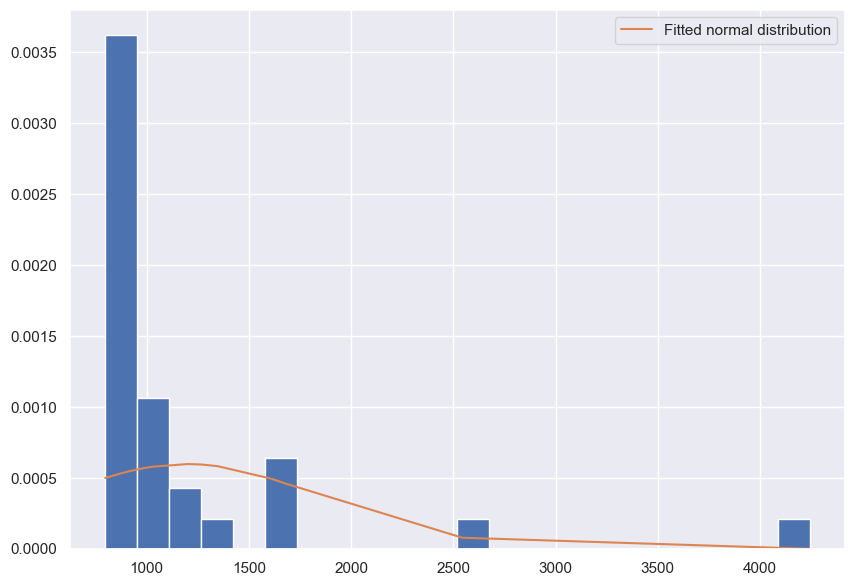

In [32]:
normal_plot(df_traj[df_traj.position == 'left'].traj_length)

In [33]:
normal_test_battery(df_traj[df_traj.position == 'left'].traj_length)

Shapiro-Wilk s=0.517 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=49.304 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=5.181854628672838
15.000: 0.521, data does not look normal (reject H0)
10.000: 0.593, data does not look normal (reject H0)
5.000: 0.712, data does not look normal (reject H0)
2.500: 0.830, data does not look normal (reject H0)
1.000: 0.988, data does not look normal (reject H0)


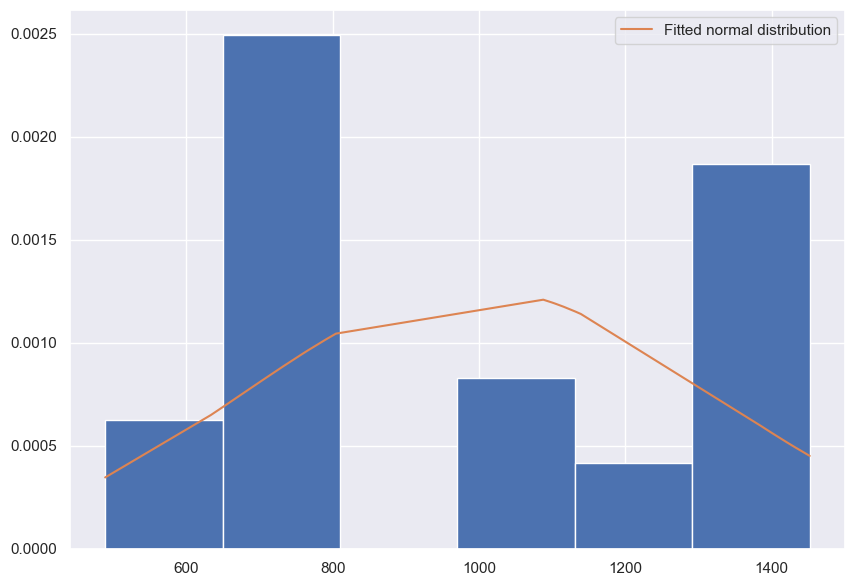

In [34]:
normal_plot(df_traj[df_traj.position == 'right'].traj_length)

In [35]:
normal_test_battery(df_traj[df_traj.position == 'right'].traj_length)

Shapiro-Wilk s=0.861 p=0.001, data does not look normal (reject H0)
D’Agostino K^2 s=19.485 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=1.7102042288982844
15.000: 0.521, data does not look normal (reject H0)
10.000: 0.593, data does not look normal (reject H0)
5.000: 0.712, data does not look normal (reject H0)
2.500: 0.830, data does not look normal (reject H0)
1.000: 0.988, data does not look normal (reject H0)


In [36]:
df_corr = pd.DataFrame()

for n, g in df_traj.groupby(by='position'):
    df_corr[n] = g.traj_length.values
    
print(rp.corr_pair(df_corr))

                r value p-value   N
centre & left   -0.0909  0.6330  30
centre & right   0.2434  0.1950  30
left & right     0.3490  0.0587  30


In [37]:
print(stats.kruskal(df_traj[df_traj.position == 'centre'].traj_length,
                    df_traj[df_traj.position == 'left'].traj_length,
                    df_traj[df_traj.position == 'right'].traj_length))

KruskalResult(statistic=2.3186324786324235, pvalue=0.31370060370659786)


# Method x position

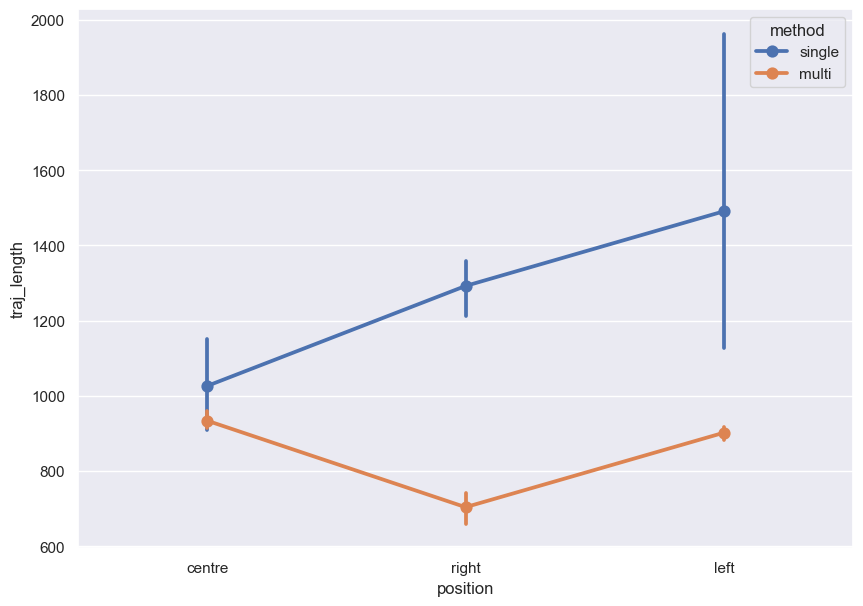

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.pointplot(data=df_traj, x='position', y='traj_length', hue='method')
plt.show()

## Normality assumption

Text(0.5, 1.0, 'multi:right')

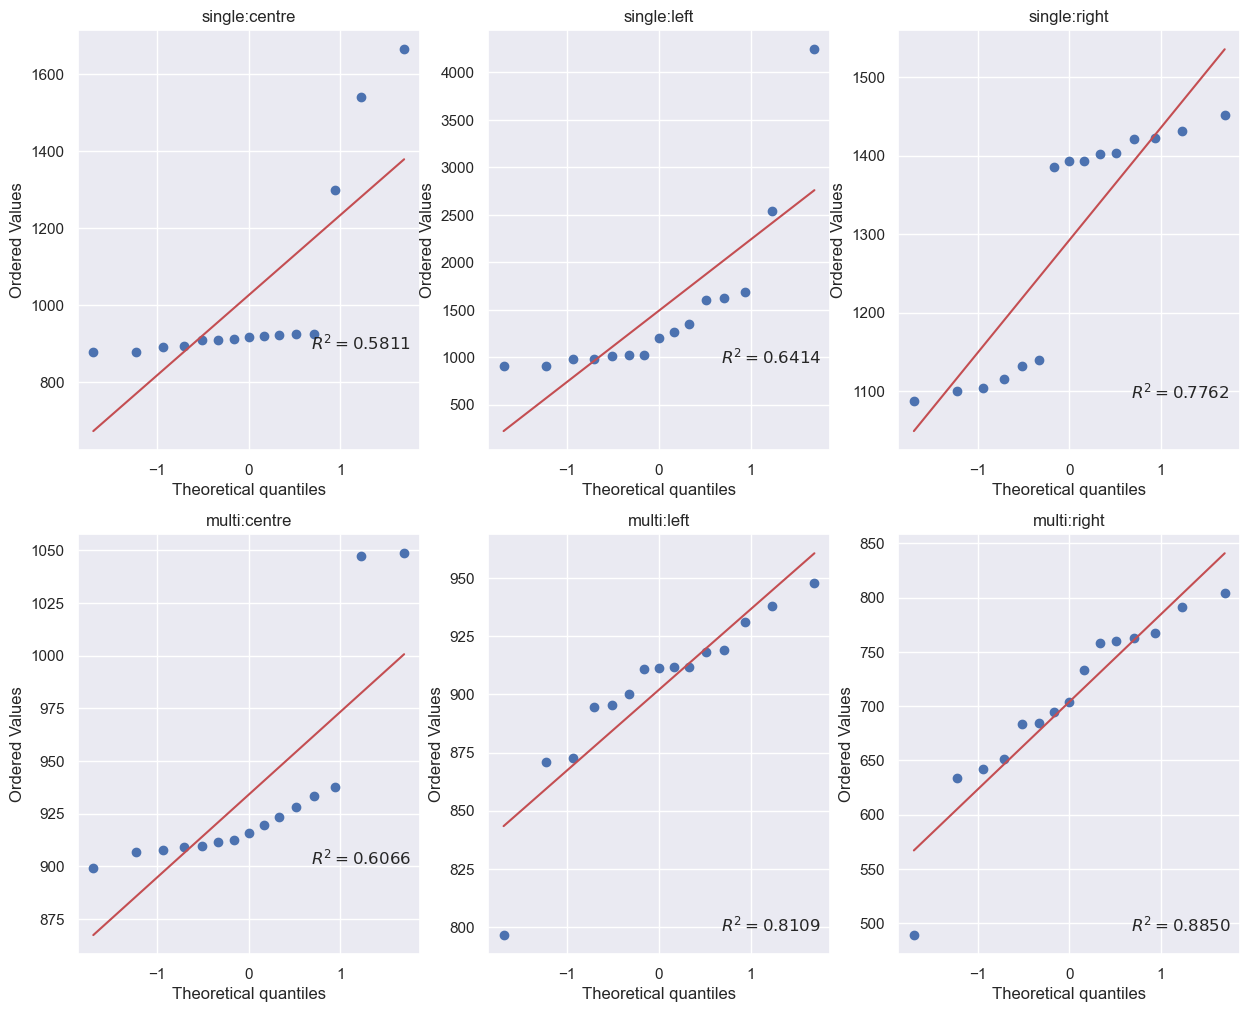

In [39]:
fig, ax = plt.subplots(2, 3, figsize= (15, 12))
stats.probplot(single[single.position == 'centre'].traj_length, plot=ax[0, 0], rvalue=True)
ax[0, 0].set_title('single:centre', fontsize=12)
stats.probplot(single[single.position == 'left'].traj_length, plot=ax[0, 1], rvalue=True)
ax[0, 1].set_title('single:left', fontsize=12)
stats.probplot(single[single.position == 'right'].traj_length, plot=ax[0, 2], rvalue=True)
ax[0, 2].set_title('single:right', fontsize=12)
stats.probplot(multi[multi.position == 'centre'].traj_length, plot=ax[1, 0], rvalue=True)
ax[1, 0].set_title('multi:centre', fontsize=12)
stats.probplot(multi[multi.position == 'left'].traj_length, plot=ax[1, 1], rvalue=True)
ax[1, 1].set_title('multi:left', fontsize=12)
stats.probplot(multi[multi.position == 'right'].traj_length, plot=ax[1, 2], rvalue=True)
ax[1, 2].set_title('multi:right', fontsize=12)

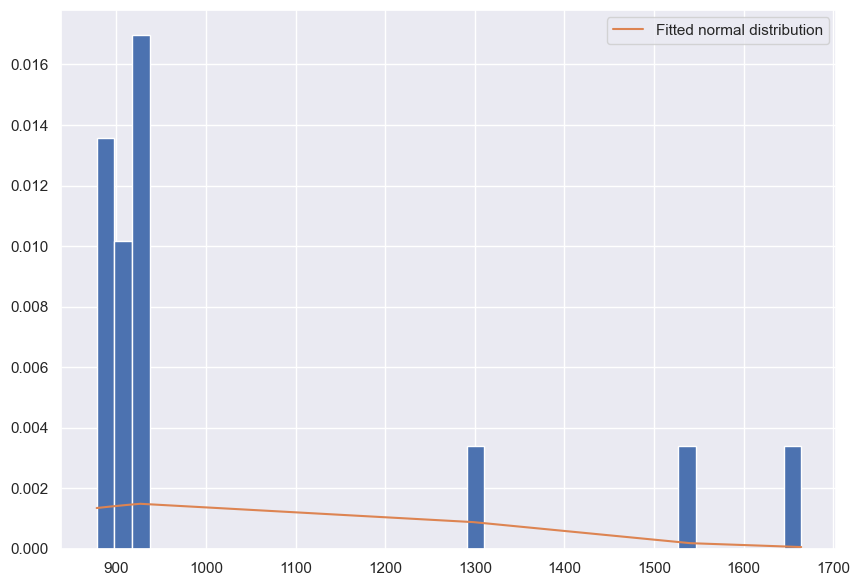

In [40]:
normal_plot(single[single.position == 'centre'].traj_length)

In [41]:
normal_test_battery(single[single.position == 'centre'].traj_length)

Shapiro-Wilk s=0.588 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=12.341 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=2.991493855799625
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


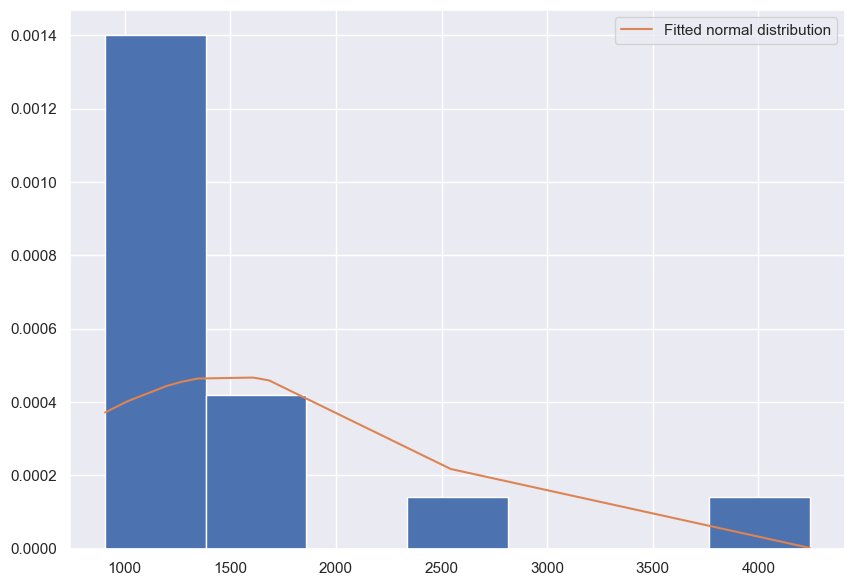

In [42]:
normal_plot(single[single.position == 'left'].traj_length)

In [43]:
normal_test_battery(single[single.position == 'left'].traj_length)

Shapiro-Wilk s=0.664 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=23.828 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=1.840738802012826
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


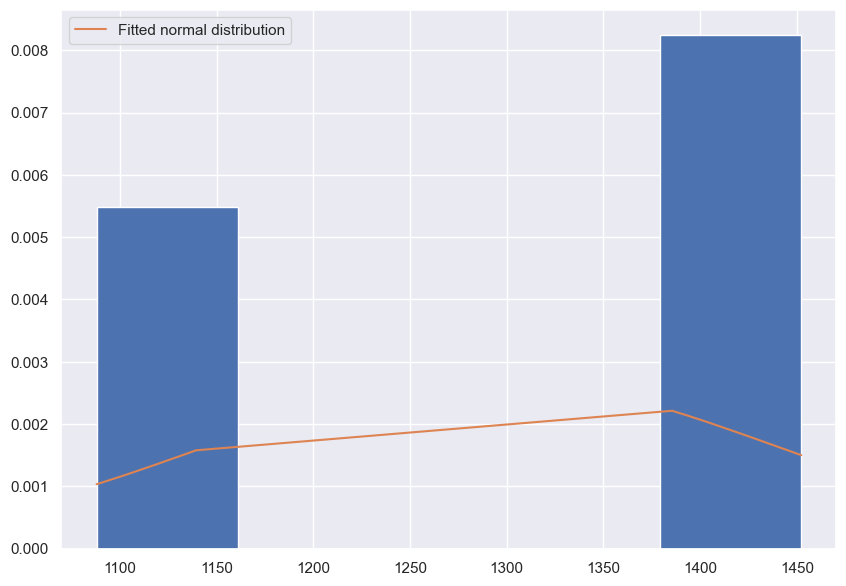

In [44]:
normal_plot(single[single.position == 'right'].traj_length)

In [45]:
normal_test_battery(single[single.position == 'right'].traj_length)

Shapiro-Wilk s=0.748 p=0.001, data does not look normal (reject H0)
D’Agostino K^2 s=12.838 p=0.002, data does not look normal (reject H0)

Anderson-Darling s=1.7638409917614126
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


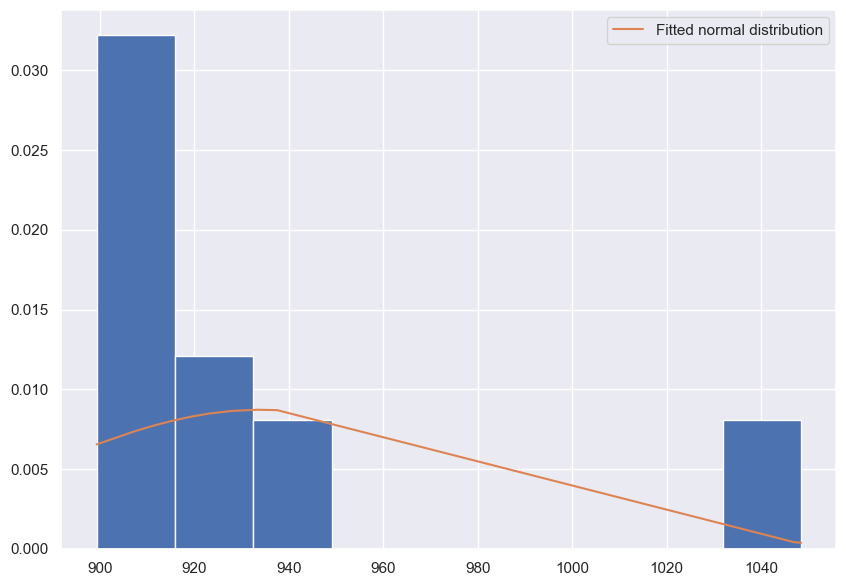

In [46]:
normal_plot(multi[multi.position == 'centre'].traj_length)

In [47]:
normal_test_battery(multi[multi.position == 'centre'].traj_length)

Shapiro-Wilk s=0.615 p=0.000, data does not look normal (reject H0)
D’Agostino K^2 s=15.951 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=2.522170491776887
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data does not look normal (reject H0)


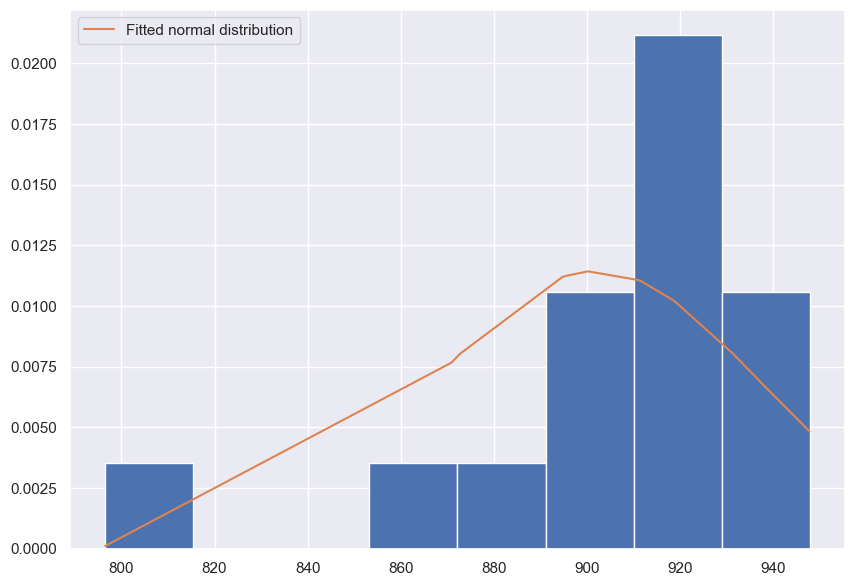

In [48]:
normal_plot(multi[multi.position == 'left'].traj_length)

In [49]:
normal_test_battery(multi[multi.position == 'left'].traj_length)

Shapiro-Wilk s=0.836 p=0.011, data does not look normal (reject H0)
D’Agostino K^2 s=15.400 p=0.000, data does not look normal (reject H0)

Anderson-Darling s=0.8507504538222772
15.000: 0.498, data does not look normal (reject H0)
10.000: 0.568, data does not look normal (reject H0)
5.000: 0.681, data does not look normal (reject H0)
2.500: 0.794, data does not look normal (reject H0)
1.000: 0.945, data looks normal (accept H0)


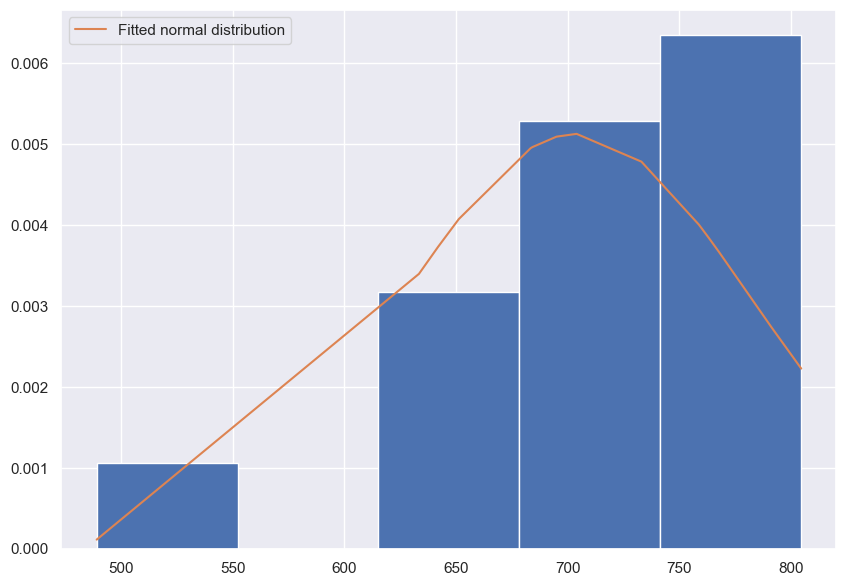

In [50]:
normal_plot(multi[multi.position == 'right'].traj_length)

In [51]:
normal_test_battery(multi[multi.position == 'right'].traj_length)

Shapiro-Wilk s=0.897 p=0.086, data looks normal (accept H0)
D’Agostino K^2 s=7.962 p=0.019, data does not look normal (reject H0)

Anderson-Darling s=0.4839466849069858
15.000: 0.498, data looks normal (accept H0)
10.000: 0.568, data looks normal (accept H0)
5.000: 0.681, data looks normal (accept H0)
2.500: 0.794, data looks normal (accept H0)
1.000: 0.945, data looks normal (accept H0)


In [52]:
df_corr = pd.DataFrame()

for n, g in single.groupby(by='position'):
    df_corr[n] = g.traj_length.values
    
print(rp.corr_pair(df_corr))

                r value p-value   N
centre & left   -0.2391  0.3908  15
centre & right   0.0128  0.9640  15
left & right    -0.1975  0.4805  15


In [53]:
df_corr = pd.DataFrame()

for n, g in multi.groupby(by='position'):
    df_corr[n] = g.traj_length.values
    
print(rp.corr_pair(df_corr))

                r value p-value   N
centre & left    0.3539  0.1956  15
centre & right   0.1921  0.4928  15
left & right    -0.2959  0.2843  15


## Single variances

In [54]:
print(stats.levene(single[single.position == 'centre'].traj_length,
                   single[single.position == 'left'].traj_length,
                   single[single.position == 'right'].traj_length))

LeveneResult(statistic=3.0850378838355375, pvalue=0.05622263299187438)


In [55]:
print(single.groupby(by='position').traj_length.describe().T)

position       centre         left        right
count       15.000000    15.000000    15.000000
mean      1026.428500  1490.937932  1292.328261
std        255.971181   876.805417   152.734095
min        877.969667   907.742957  1087.988719
25%        902.155217  1000.289456  1124.093510
50%        919.124114  1199.627792  1393.297023
75%        926.419276  1616.538685  1412.270506
max       1664.219887  4243.018440  1452.240237


## Single non-parametric testing

In [56]:
print(stats.kruskal(single[single.position == 'centre'].traj_length,
                    single[single.position == 'left'].traj_length,
                    single[single.position == 'right'].traj_length))

KruskalResult(statistic=12.172367149758458, pvalue=0.002274071197267902)


In [57]:
print(sp.posthoc_dunn(single, val_col='traj_length', group_col='position', p_adjust='bonferroni'))

          centre      left     right
centre  1.000000  0.026895  0.002815
left    0.026895  1.000000  1.000000
right   0.002815  1.000000  1.000000


## Multi variances

In [58]:
print(stats.levene(multi[multi.position == 'centre'].traj_length,
                   multi[multi.position == 'left'].traj_length,
                   multi[multi.position == 'right'].traj_length))

LeveneResult(statistic=3.636578413306397, pvalue=0.034947568194938876)


In [59]:
print(multi.groupby(by='position').traj_length.describe().T)

position       centre        left       right
count       15.000000   15.000000   15.000000
mean       933.987618  902.028653  703.984437
std         47.361369   36.067512   80.592239
min        899.342824  796.514823  489.020087
25%        909.437452  895.090778  667.282399
50%        915.757067  911.169232  703.938492
75%        930.667003  918.691982  761.390361
max       1048.509573  947.792202  804.530300


## Multi non-parametric testing

In [60]:
print(stats.kruskal(multi[multi.position == 'centre'].traj_length,
                    multi[multi.position == 'left'].traj_length,
                    multi[multi.position == 'right'].traj_length))

KruskalResult(statistic=30.203671497584537, pvalue=2.7628421162601205e-07)


In [61]:
print(sp.posthoc_dunn(multi, val_col='traj_length', group_col='position', p_adjust='bonferroni'))

              centre      left         right
centre  1.000000e+00  0.872256  6.012219e-07
left    8.722565e-01  1.000000  1.030682e-04
right   6.012219e-07  0.000103  1.000000e+00


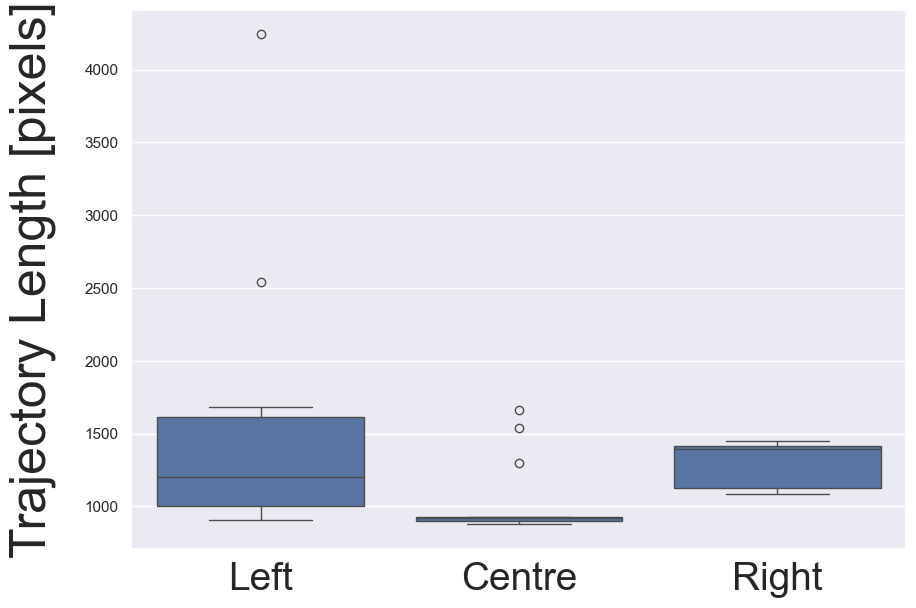

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=single, x='position', y='traj_length', order=['left', 'centre', 'right'])
ax.set_ylabel('Trajectory Length [pixels]', fontsize=18*2, labelpad=20)
ax.set_xlabel('', fontsize=18*2, labelpad=20)
ax.set_xticklabels(['Left', 'Centre', 'Right'], fontsize=14*2)
plt.savefig('single_position.png')
plt.show()

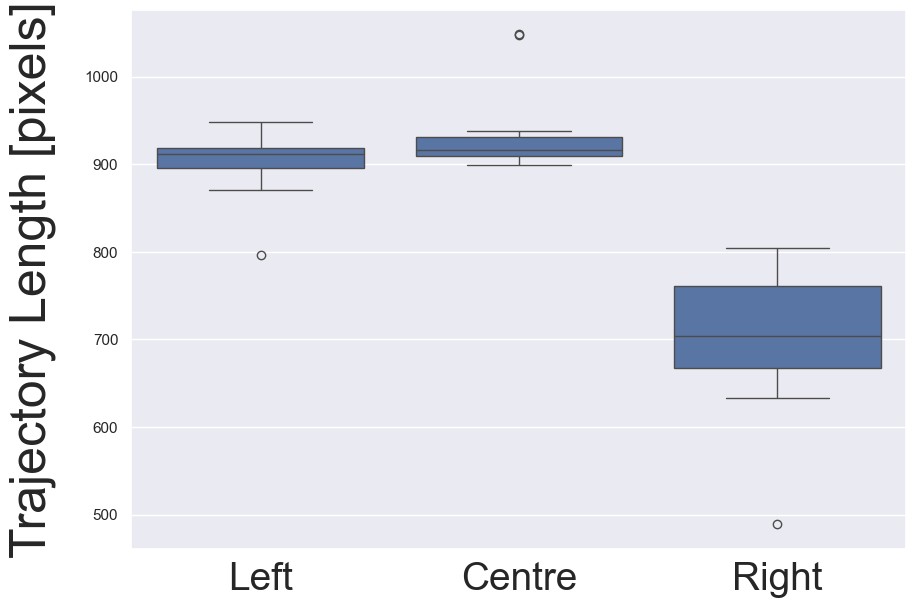

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=multi, x='position', y='traj_length', order=['left', 'centre', 'right'])
ax.set_ylabel('Trajectory Length [pixels]', fontsize=18*2, labelpad=20)
ax.set_xlabel('', fontsize=18*2, labelpad=20)
ax.set_xticklabels(['Left', 'Centre', 'Right'], fontsize=14*2)
plt.savefig('multi_position.png')
plt.show()

# Position x method

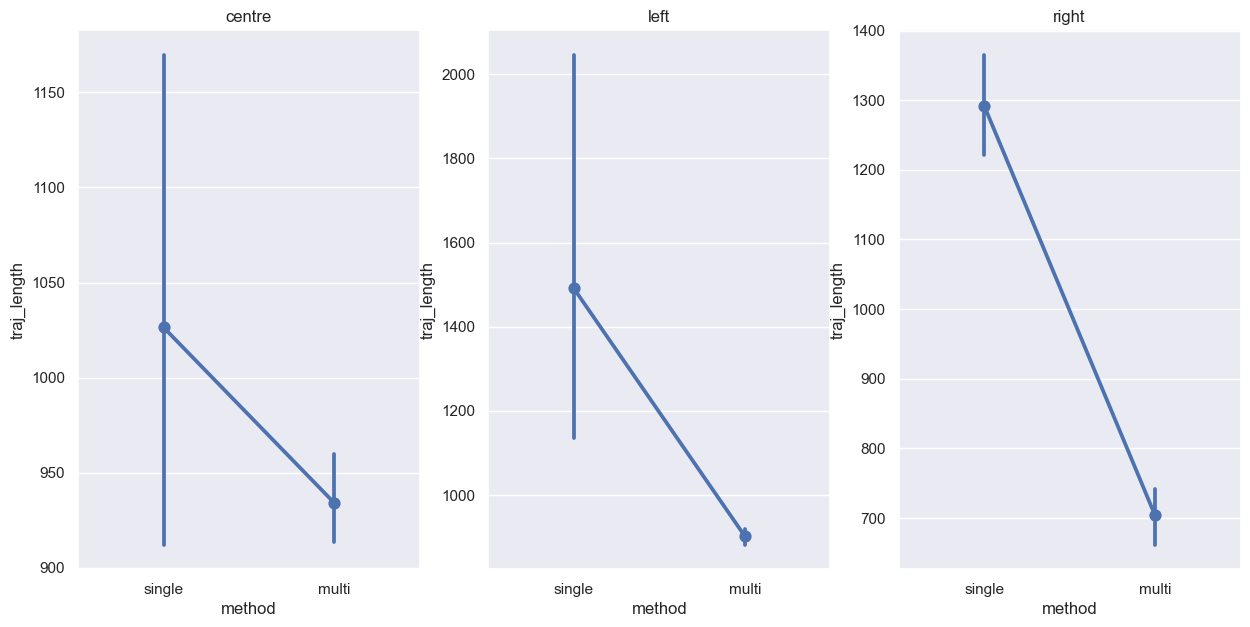

In [64]:
centre = df_traj[df_traj.position == 'centre']
left = df_traj[df_traj.position == 'left']
right = df_traj[df_traj.position == 'right']

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
sns.pointplot(data=centre, x='method', y='traj_length', ax=ax[0])
sns.pointplot(data=left, x='method', y='traj_length', ax=ax[1])
sns.pointplot(data=right, x='method', y='traj_length', ax=ax[2])

ax[0].set_title('centre')
ax[1].set_title('left')
ax[2].set_title('right')

plt.show()

## Centre variances

In [65]:
print(stats.levene(centre[centre.method == 'single'].traj_length,
                   centre[centre.method == 'multi'].traj_length))

LeveneResult(statistic=2.55387243115931, pvalue=0.1212496482328129)


In [66]:
print(centre.groupby(by='method').describe().T)

method                   multi       single
traj_length count    15.000000    15.000000
            mean    933.987618  1026.428500
            std      47.361369   255.971181
            min     899.342824   877.969667
            25%     909.437452   902.155217
            50%     915.757067   919.124114
            75%     930.667003   926.419276
            max    1048.509573  1664.219887
rank        count    15.000000    15.000000
            mean     42.933333    45.200000
            std      12.958542    22.033092
            min      25.000000    19.000000
            25%      31.000000    27.500000
            50%      42.000000    45.000000
            75%      53.000000    50.500000
            max      64.000000    87.000000


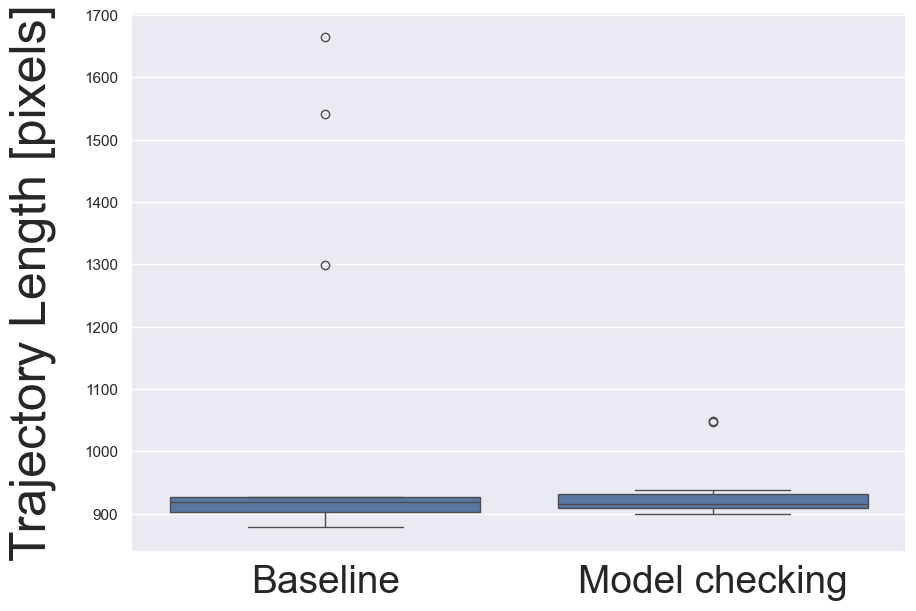

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=centre, x='method', y='traj_length')
ax.set_ylabel('Trajectory Length [pixels]', fontsize=18*2, labelpad=20)
ax.set_xlabel('', fontsize=18*2, labelpad=20)
ax.set_xticklabels(['Baseline', 'Model checking'], fontsize=14*2)
plt.savefig('centre.png')
plt.show()

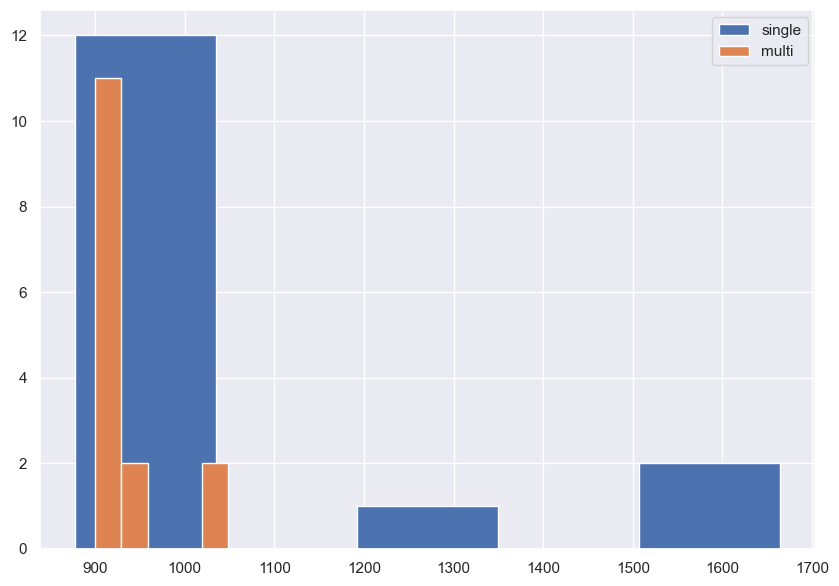

In [68]:
plt.figure(figsize=(10, 7))
centre[centre.method == 'single'].traj_length.hist(label='single', bins=5)
centre[centre.method == 'multi'].traj_length.hist(label='multi', bins=5)
plt.legend()
plt.show()

## Centre non-parametric testing

In [69]:
stats.mannwhitneyu(centre[centre.method == 'multi'].traj_length,
                   centre[centre.method == 'single'].traj_length, alternative='less')

MannwhitneyuResult(statistic=116.0, pvalue=0.5658870048237823)

In [70]:
centre['rank'] = centre.traj_length.rank(method='min').values
single_ranked = centre[centre.method == 'single']
multi_ranked = centre[centre.method == 'multi']

mannwhitney_stats(single_ranked['rank'],
                  multi_ranked['rank'])

Sum of ranks sample 1: 229.0
Mean rank sample 1: 15.266666666666667
U sample 1: 116.0

Sum of ranks sample 2: 236.0
Mean rank sample 2: 15.733333333333333
U sample 2: 109.0

Test stat U: 109.0
Expected value of U: 112.5
Standard error of U: 59.055059055088584
z-value: -0.059266725933422235
Effect size r=0.015302602834958903


Permutation test pvalue=0.4997350026499735


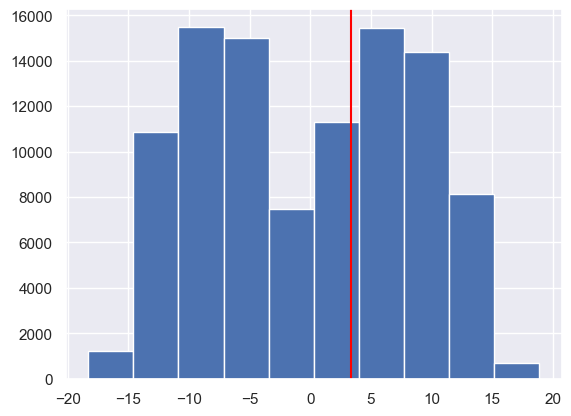

In [71]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((centre[centre.method == 'single'].traj_length.values,
                                 centre[centre.method == 'multi'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(centre[centre.method == 'single'].traj_length.values, 
                      centre[centre.method == 'multi'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=0.1104888951110489


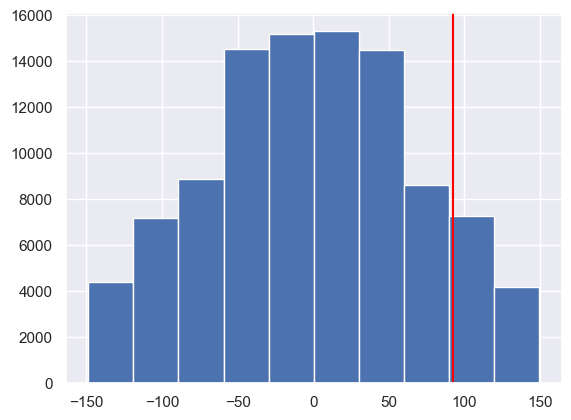

In [72]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((centre[centre.method == 'single'].traj_length.values,
                                 centre[centre.method == 'multi'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(centre[centre.method == 'single'].traj_length.values, 
                      centre[centre.method == 'multi'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

## Left variances

In [73]:
print(stats.levene(left[left.method == 'single'].traj_length,
                   left[left.method == 'multi'].traj_length))

LeveneResult(statistic=5.701427832069148, pvalue=0.023939601676714935)


In [74]:
print(left.groupby(by='method').describe().T)

method                  multi       single
traj_length count   15.000000    15.000000
            mean   902.028653  1490.937932
            std     36.067512   876.805417
            min    796.514823   907.742957
            25%    895.090778  1000.289456
            50%    911.169232  1199.627792
            75%    918.691982  1616.538685
            max    947.792202  4243.018440
rank        count   15.000000    15.000000
            mean    34.733333    67.666667
            std     14.073616    19.304576
            min     15.000000    29.000000
            25%     23.500000    59.500000
            50%     35.000000    71.000000
            75%     43.500000    85.500000
            max     57.000000    90.000000


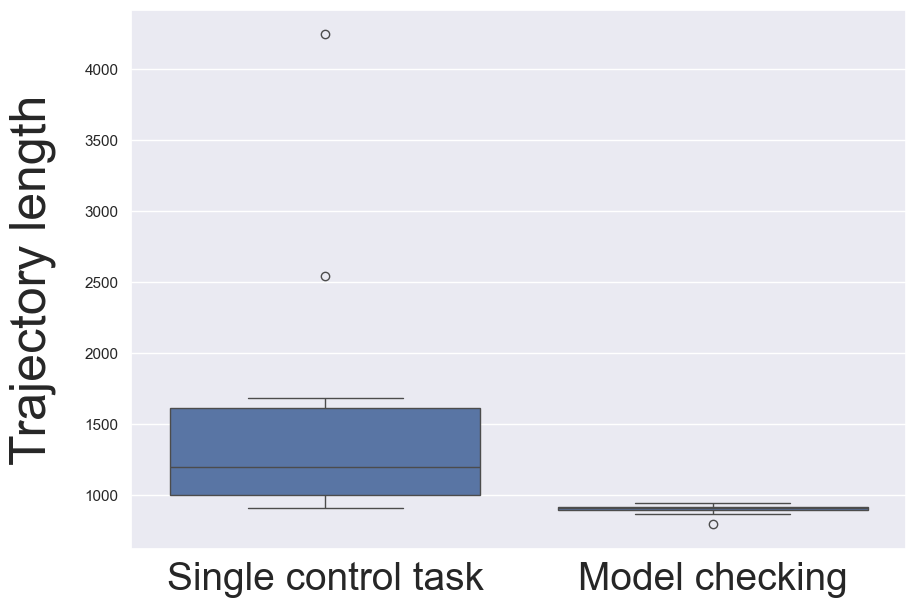

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=left, x='method', y='traj_length')
ax.set_ylabel('Trajectory length', fontsize=18*2, labelpad=20)
ax.set_xlabel('', fontsize=18*2, labelpad=20)
ax.set_xticklabels(['Single control task', 'Model checking'], fontsize=14*2)
plt.savefig('left.png')
plt.show()

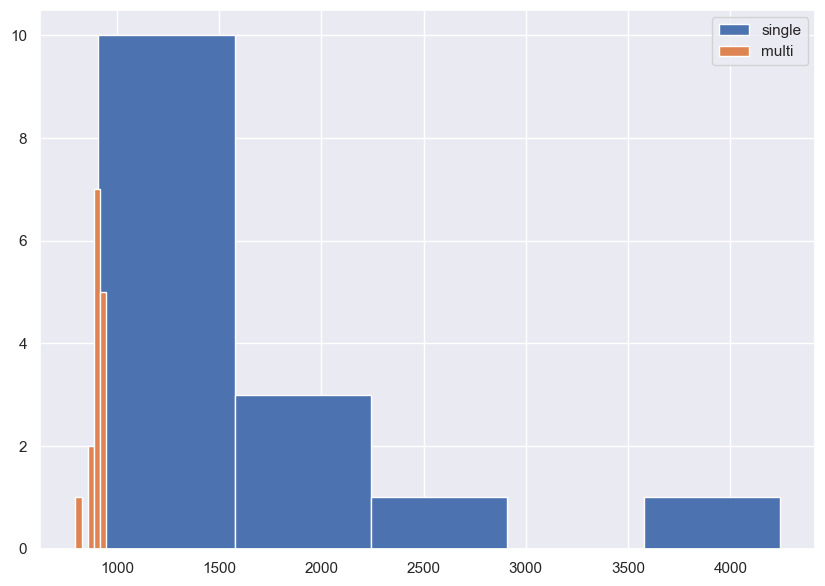

In [76]:
plt.figure(figsize=(10, 7))
left[left.method == 'single'].traj_length.hist(label='single', bins=5)
left[left.method == 'multi'].traj_length.hist(label='multi', bins=5)
plt.legend()
plt.show()

## Left non-parametric testing

In [77]:
print(stats.mannwhitneyu(left[left.method == 'multi'].traj_length,
                         left[left.method == 'single'].traj_length, alternative='less'))

MannwhitneyuResult(statistic=18.0, pvalue=4.8307679350761596e-05)


In [78]:
left['rank'] = left.traj_length.rank(method='min').values
single_ranked = left[left.method == 'single']
multi_ranked = left[left.method == 'multi']

mannwhitney_stats(single_ranked['rank'],
                  multi_ranked['rank'])

Sum of ranks sample 1: 327.0
Mean rank sample 1: 21.8
U sample 1: 18.0

Sum of ranks sample 2: 138.0
Mean rank sample 2: 9.2
U sample 2: 207.0

Test stat U: 18.0
Expected value of U: 112.5
Standard error of U: 59.055059055088584
z-value: -1.6002016002024002
Effect size r=0.4131702765438903


Permutation test pvalue=0.0002099979000209998


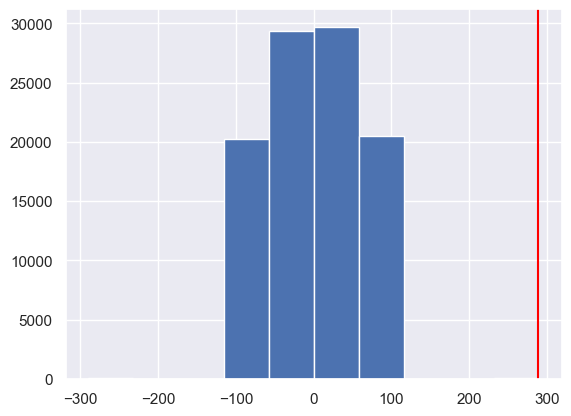

In [79]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((left[left.method == 'single'].traj_length.values,
                                 left[left.method == 'multi'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(left[left.method == 'single'].traj_length.values, 
                      left[left.method == 'multi'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=9.99990000099999e-06


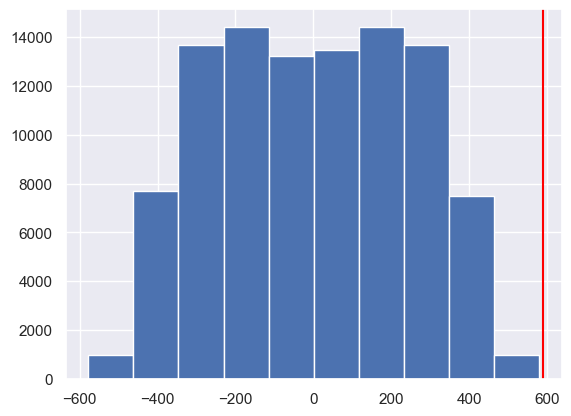

In [80]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((left[left.method == 'single'].traj_length.values,
                                 left[left.method == 'multi'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(left[left.method == 'single'].traj_length.values, 
                      left[left.method == 'multi'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

## Right variances

In [81]:
print(stats.levene(right[right.method == 'single'].traj_length,
                   right[right.method == 'multi'].traj_length))

LeveneResult(statistic=3.0297716295656847, pvalue=0.09273017141997877)


In [82]:
print(right.groupby(by='method').describe().T)

method                  multi       single
traj_length count   15.000000    15.000000
            mean   703.984437  1292.328261
            std     80.592239   152.734095
            min    489.020087  1087.988719
            25%    667.282399  1124.093510
            50%    703.938492  1393.297023
            75%    761.390361  1412.270506
            max    804.530300  1452.240237
rank        count   15.000000    15.000000
            mean     8.066667    74.400000
            std      4.589844     6.288311
            min      1.000000    65.000000
            25%      4.500000    68.500000
            50%      8.000000    76.000000
            75%     11.500000    79.500000
            max     16.000000    83.000000


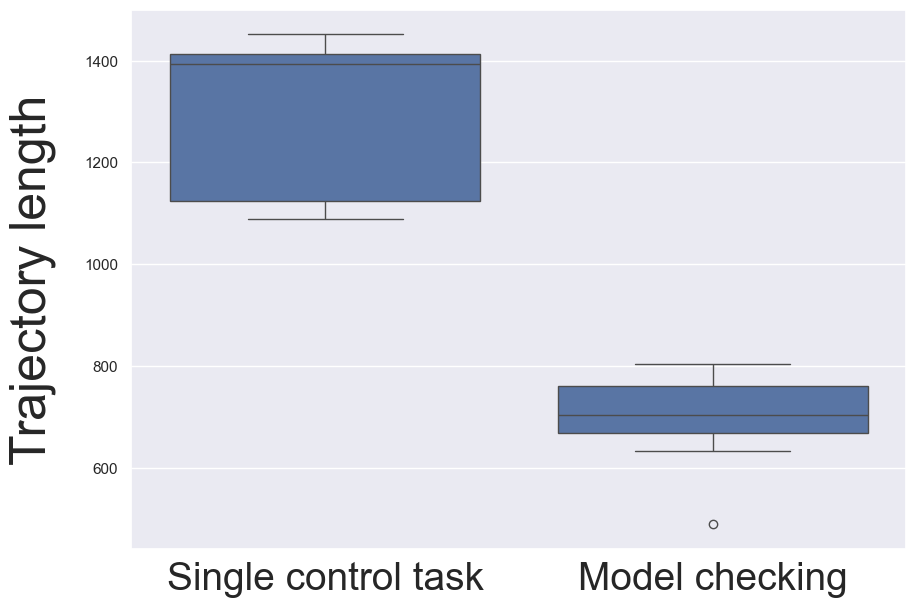

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.boxplot(data=right, x='method', y='traj_length')
ax.set_ylabel('Trajectory length', fontsize=18*2, labelpad=20)
ax.set_xlabel('', fontsize=18*2, labelpad=20)
ax.set_xticklabels(['Single control task', 'Model checking'], fontsize=14*2)
plt.savefig('right.png')
plt.show()

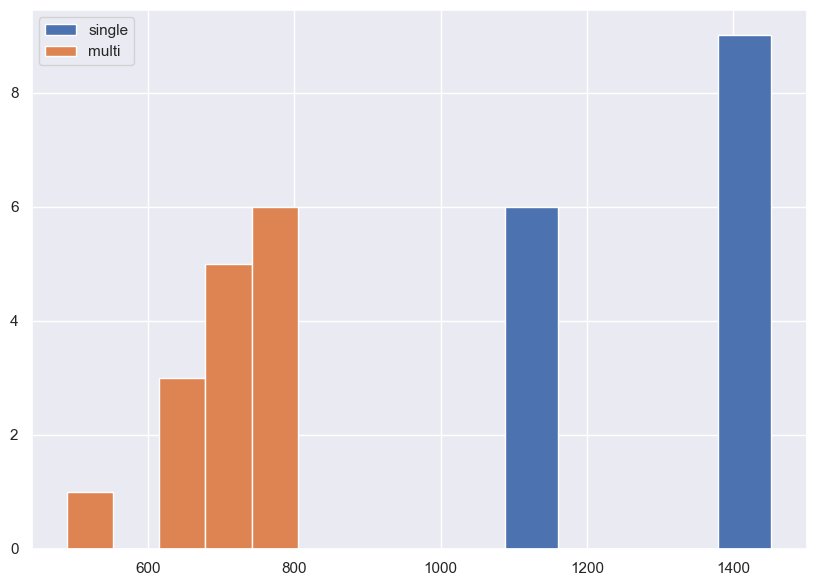

In [84]:
plt.figure(figsize=(10, 7))
right[right.method == 'single'].traj_length.hist(label='single', bins=5)
right[right.method == 'multi'].traj_length.hist(label='multi', bins=5)
plt.legend()
plt.show()

## Right non-parametric testing

In [85]:
print(stats.mannwhitneyu(right[right.method == 'multi'].traj_length,
                         right[right.method == 'single'].traj_length, alternative='less'))

MannwhitneyuResult(statistic=0.0, pvalue=1.6959106954125473e-06)


In [86]:
right['rank'] = right.traj_length.rank(method='min').values
single_ranked = right[right.method == 'single']
multi_ranked = right[right.method == 'multi']

mannwhitney_stats(single_ranked['rank'],
                  multi_ranked['rank'])

Sum of ranks sample 1: 345.0
Mean rank sample 1: 23.0
U sample 1: 0.0

Sum of ranks sample 2: 120.0
Mean rank sample 2: 8.0
U sample 2: 225.0

Test stat U: 0.0
Expected value of U: 112.5
Standard error of U: 59.055059055088584
z-value: -1.9050019050028575
Effect size r=0.4918693768379647


Permutation test pvalue=1.999980000199998e-05


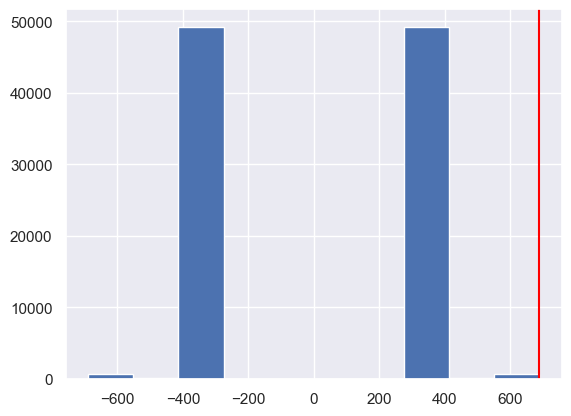

In [87]:
def statistic(x, y, axis=0):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

result = stats.permutation_test((right[right.method == 'single'].traj_length.values,
                                 right[right.method == 'multi'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(right[right.method == 'single'].traj_length.values, 
                      right[right.method == 'multi'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

Permutation test pvalue=9.99990000099999e-06


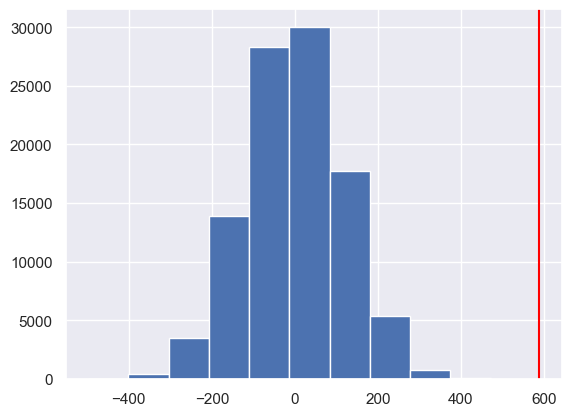

In [88]:
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

result = stats.permutation_test((right[right.method == 'single'].traj_length.values,
                                 right[right.method == 'multi'].traj_length.values), 
                                 statistic=statistic, n_resamples=100000, alternative='greater')

reference = statistic(right[right.method == 'single'].traj_length.values, 
                      right[right.method == 'multi'].traj_length.values)

plt.hist(result.null_distribution, bins=10)
plt.axvline(reference, color='red')
print('Permutation test pvalue={}'.format(result.pvalue))

# Resource usage

In [89]:
mem_usage = (df[df.method == 'multi'].max_stack_capacity * df[df.method == 'multi'].state_size).max() + \
(df[df.method == 'multi'].max_set_size * df[df.method == 'multi'].state_size).max() + \
(df[df.method == 'multi'].n_states * df[df.method == 'multi'].state_size).max() + \
df[df.method == 'multi'].adj_list_compile.max() + df[df.method == 'multi'].stack_compile.max() + \
df[df.method == 'multi'].set_compile.max()

print('Estimated model checking memory usage: {} KB'.format(mem_usage * 8 / 1024))

Estimated model checking memory usage: 2.90625 KB


In [90]:
df[df.method == 'multi'].shr_max.max() / 1024

3.34375

In [91]:
df[df.method == 'multi'].res_max.max() - df[df.method == 'multi'].shr_max.max(), df[df.method == 'multi'].res_max.max() / 1024

(992, 4.3125)

In [92]:
2.9 / 992

0.0029233870967741936

In [93]:
2.9 / (4.3125 * 1024)

0.0006567028985507246

In [94]:
df[df.method == 'single'].shr_max.max() / 1024

3.27734375

In [95]:
(df[df.method == 'single'].res_max.max() - df[df.method == 'single'].shr_max.max()) / 1024, df[df.method == 'single'].res_max.max() / 1024

(1.0234375, 4.30078125)

# Processing latency

In [96]:
print(df.latency1.describe())

count    45.000000
mean      9.672000
std       2.747765
min       5.581000
25%       7.831000
50%       8.665000
75%      11.607000
max      15.557000
Name: latency1, dtype: float64


<Axes: >

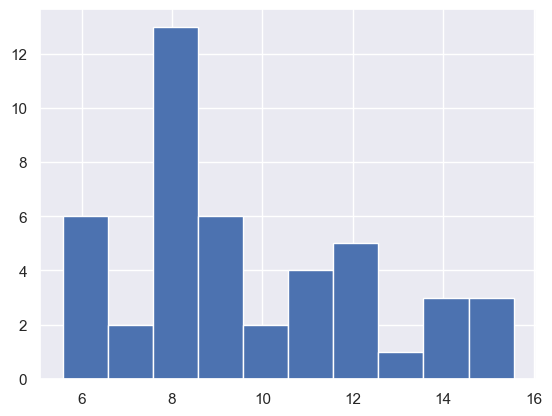

In [97]:
df.latency1.hist()

In [98]:
print(df.latency2.describe())

count     6.000000
mean     13.286333
std       3.689776
min       8.721000
25%      10.817750
50%      12.967500
75%      15.390250
max      18.763000
Name: latency2, dtype: float64


<Axes: >

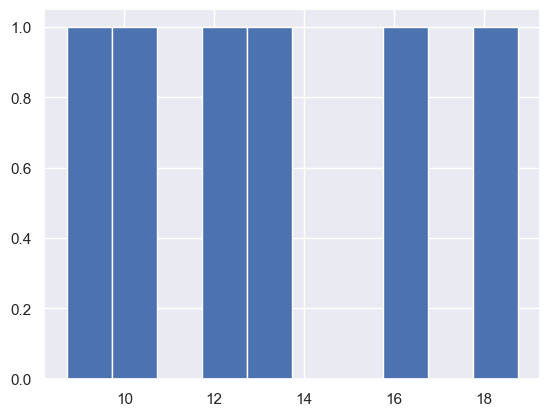

In [99]:
df.latency2.hist()

In [100]:
data = []

for i in range(len(df)):
    data.append(df.latency1.iloc[i])
    data.append(df.latency2.iloc[i])
    
df_latency = pd.DataFrame(data=data, columns=['latency'])
df_latency = df_latency.dropna(axis=0)
print(df_latency.head())

    latency
30   12.517
32    8.791
34    8.025
35   10.290
36    8.305


(array([ 7.,  9., 12.,  4.,  5.,  5.,  5.,  3.,  0.,  1.]),
 array([ 5.581 ,  6.8992,  8.2174,  9.5356, 10.8538, 12.172 , 13.4902,
        14.8084, 16.1266, 17.4448, 18.763 ]),
 <BarContainer object of 10 artists>)

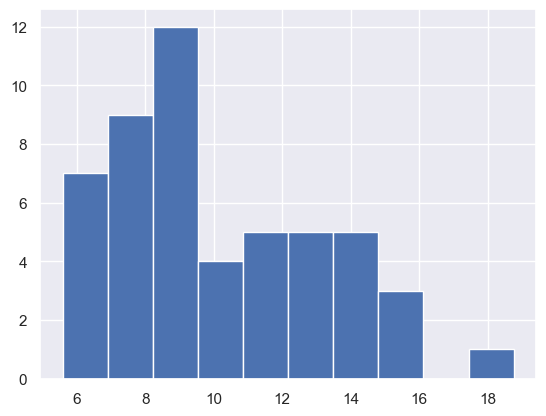

In [101]:
plt.hist(df_latency.latency)

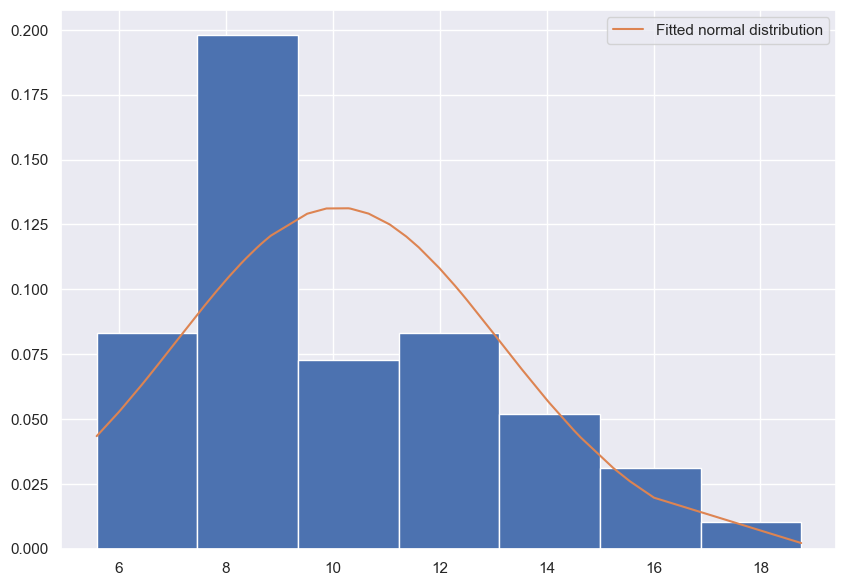

In [102]:
normal_plot(df_latency.latency)

In [103]:
normal_test_battery(df_latency.latency)

Shapiro-Wilk s=0.937 p=0.009, data does not look normal (reject H0)
D’Agostino K^2 s=4.677 p=0.096, data looks normal (accept H0)

Anderson-Darling s=1.171314156118406
15.000: 0.539, data does not look normal (reject H0)
10.000: 0.614, data does not look normal (reject H0)
5.000: 0.736, data does not look normal (reject H0)
2.500: 0.859, data does not look normal (reject H0)
1.000: 1.022, data does not look normal (reject H0)


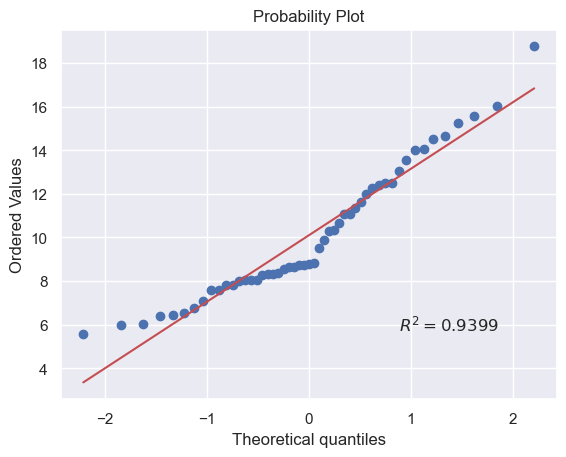

In [104]:
stats.probplot(df_latency.latency, plot=plt, rvalue=True); plt.show()

In [105]:
print(df_latency.latency.describe())

count    51.000000
mean     10.097216
std       3.064118
min       5.581000
25%       8.031500
50%       8.791000
75%      12.344500
max      18.763000
Name: latency, dtype: float64


ConfidenceInterval(low=9.320167621342087, high=11.004877600739214)


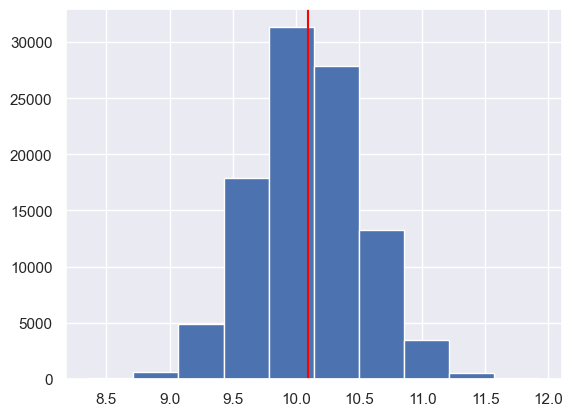

In [106]:
result = stats.bootstrap((df_latency.latency, ), 
                          statistic=np.mean, 
                          n_resamples=100000,
                          confidence_level=0.95)

reference = df_latency.latency.mean()
plt.hist(result.bootstrap_distribution, bins=10)
plt.axvline(reference, color='red')
print(result.confidence_interval)

# Collisions

In [107]:
print(df.groupby(by='method').collisions.sum())

method
multi     0
single    3
Name: collisions, dtype: int64


In [108]:
print(df.groupby(by=['position']).collisions.sum())

position
centre    1
left      2
right     0
Name: collisions, dtype: int64


In [109]:
print(df[df.collisions == 1].traj_length)

3     1540.525885
62    1684.529283
66    1627.692669
Name: traj_length, dtype: float64


In [110]:
single.traj_length.describe()

count      45.000000
mean     1269.898231
std       556.705021
min       877.969667
25%       923.995354
50%      1115.916107
75%      1403.412626
max      4243.018440
Name: traj_length, dtype: float64

In [111]:
3 / 45

0.06666666666666667

https://datatab.net/tutorial/mann-whitney-u-test

https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics-2.php

https://journals.sagepub.com/doi/pdf/10.1177/1536867X1501500117

https://statisticsbyjim.com/hypothesis-testing/bootstrapping/

https://stats.stackexchange.com/questions/479348/what-is-mean-rank

https://www.linux.com/training-tutorials/uncover-meaning-tops-statistics/

https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test